In [452]:
# Kaggle 타이타닉 문제는 타이타닉의 승객 중에 생존 유무를 예측하는 것이다.
# 아래의 코드는 https://www.kaggle.com/startupsci/titanic-data-science-solutions 를 참고해서 작성하였다.

In [453]:
# Numpy, Pandas 불러오기
import numpy as np
import pandas as pd

# 시각화 라이브러리 불러오기
import matplotlib.pyplot as plt
import seaborn as sns

# Scikit-learn 머신러닝 라이브러리 불러오기
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import Perceptron
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import cross_val_score, KFold
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from xgboost import XGBClassifier

In [454]:
# 데이터 불러오기
train = pd.read_csv('/python/titanic/train.csv')
test = pd.read_csv('/python/titanic/test.csv')
total = [train, test]

In [455]:
# 전체 데이터에 대한 요약
print(train.describe())
print('-'*20)
print(test.describe())

       PassengerId    Survived      Pclass         Age       SibSp  \
count   891.000000  891.000000  891.000000  714.000000  891.000000   
mean    446.000000    0.383838    2.308642   29.699118    0.523008   
std     257.353842    0.486592    0.836071   14.526497    1.102743   
min       1.000000    0.000000    1.000000    0.420000    0.000000   
25%     223.500000    0.000000    2.000000   20.125000    0.000000   
50%     446.000000    0.000000    3.000000   28.000000    0.000000   
75%     668.500000    1.000000    3.000000   38.000000    1.000000   
max     891.000000    1.000000    3.000000   80.000000    8.000000   

            Parch        Fare  
count  891.000000  891.000000  
mean     0.381594   32.204208  
std      0.806057   49.693429  
min      0.000000    0.000000  
25%      0.000000    7.910400  
50%      0.000000   14.454200  
75%      0.000000   31.000000  
max      6.000000  512.329200  
--------------------
       PassengerId      Pclass         Age       SibSp      

In [456]:
# Training, Test 세트의 결측치 확인하기
# Age, Cabin, Fare, Embarked에서 결측치가 있다.
print(train.isnull().sum())
print('-'*20)
print(test.isnull().sum())

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64
--------------------
PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64


In [457]:
# 카테고리형 특성들의 생존율과의 연관성을 살펴본다.
print(train[['SibSp', 'Survived']].groupby(['SibSp'], as_index=False).mean().sort_values(by='Survived', ascending=False))
print('-'*20)
print(train[['Parch', 'Survived']].groupby(['Parch'], as_index=False).mean().sort_values(by='Survived', ascending=False))
print('-'*20)
print(train[['Pclass', 'Survived']].groupby(['Pclass'], as_index=False).mean().sort_values(by='Survived', ascending=False))
print('-'*20)
print(train[['Sex', 'Survived']].groupby(['Sex'], as_index=False).mean().sort_values(by='Survived', ascending=False))

   SibSp  Survived
1      1  0.535885
2      2  0.464286
0      0  0.345395
3      3  0.250000
4      4  0.166667
5      5  0.000000
6      8  0.000000
--------------------
   Parch  Survived
3      3  0.600000
1      1  0.550847
2      2  0.500000
0      0  0.343658
5      5  0.200000
4      4  0.000000
6      6  0.000000
--------------------
   Pclass  Survived
0       1  0.629630
1       2  0.472826
2       3  0.242363
--------------------
      Sex  Survived
0  female  0.742038
1    male  0.188908


In [458]:
# Ticket에서는 유의미한 특성을 찾아내지 못해서 Ticket을 제거합니다.
print(train['Ticket'].value_counts())

for data in total:
    data.drop(['Ticket'], axis=1, inplace=True)

1601        7
CA. 2343    7
347082      7
347088      6
CA 2144     6
           ..
7540        1
2683        1
248731      1
349910      1
2626        1
Name: Ticket, Length: 681, dtype: int64


In [459]:
# Cabin을 알파벳 첫번째 글자로 구분하고 Pclass 기준으로 중간값으로 결측치를 채웁니다.
for data in total:
    data['Cabin'] = data['Cabin'].str[:1]
    data['Cabin'] = data['Cabin'].map({'A': 0, 'B': 1, 'C': 2, 'D': 3, 'E': 4, 'F': 5, 'G': 6, 'T': 7})
    data['Cabin'].fillna(data.groupby('Pclass')['Cabin'].transform('median'), inplace=True)

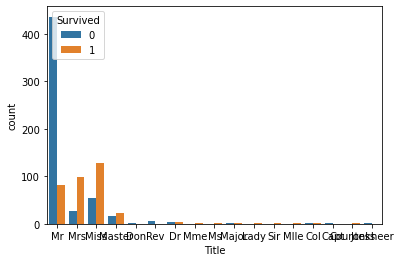

Sex       female  male
Title                 
Capt           0     1
Col            0     2
Countess       1     0
Don            0     1
Dr             1     6
Jonkheer       0     1
Lady           1     0
Major          0     2
Master         0    40
Miss         182     0
Mlle           2     0
Mme            1     0
Mr             0   517
Mrs          125     0
Ms             1     0
Rev            0     6
Sir            0     1
------------------------------
    Title  Survived
0  Master  0.575000
1    Miss  0.702703
2      Mr  0.156673
3     Mrs  0.793651
4  Others  0.347826


In [460]:
# Name에서 Title으로 추출해서 구분한다.
for data in total:
    data['Title'] = data['Name'].str.extract(' ([A-Za-z]+)\.', expand=False)

# 여성과 Master라는 Title을 가진 남성이 생존율이 높다.
sns.countplot(data=train, x='Title', hue='Survived')
plt.show()
print(pd.crosstab(train['Title'], train['Sex']))
print('-'*30)

# 희귀한 Title은 Others로 변환한다.
for data in total:
    data['Title'] = data['Title'].replace(['Lady', 'Countess', 'Capt', 'Col',\
        'Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Others')
    data['Title'] = data['Title'].replace('Mlle', 'Miss')
    data['Title'] = data['Title'].replace('Ms', 'Miss')
    data['Title'] = data['Title'].replace('Mme', 'Mrs')

# Title과 생존율과의 연관성을 살펴본다.
print(train[['Title', 'Survived']].groupby(['Title'], as_index=False).mean())

# Title을 카테고리형으로 변환하고 이후에 Name은 삭제한다.
for data in total:
    data['Title'] = data['Title'].astype('category').cat.codes
    data.drop(['Name'], axis=1, inplace=True)

In [461]:
# Pclass, 즉 선실등급에 따른 Fare가 다름을 확인한다.
print(train[['Fare', 'Pclass']].groupby(['Pclass'], as_index=False).mean())

# Fare 결측치를 Pclass 기준으로 중간값을 채우고 분위수 기준으로 구간을 나눈다.
for data in total:
    data['Fare'].fillna(data.groupby('Pclass')['Fare'].transform('median'), inplace=True)
    data['Fare'] = pd.qcut(data['Fare'], 10, labels=False)

   Pclass       Fare
0       1  84.154687
1       2  20.662183
2       3  13.675550


In [462]:
# Sex를 0과 1로 나눕니다.
for data in total:
    data['Sex'] = data['Sex'].map({'male': 0, 'female': 1}).astype(int)

In [463]:
# Age는 Pclass과 연관이 있는걸로 보인다.
print(train[['Age', 'Pclass']].groupby(['Pclass'], as_index=False).mean())

# Age의 결측치를 Pclass을 기준으로 중간값으로 채운다.
for data in total:
    data['Age'].fillna(data.groupby('Pclass')['Age'].transform('median'), inplace=True)
    
# Age를 구간을 임의로 나눠서 분류한다.
for data in total:
    data['Age'] = pd.cut(data['Age'], [0, 10, 15, 20, 25, 30, 35, 40, 45, 50, 60, 100], labels=False)

   Pclass        Age
0       1  38.233441
1       2  29.877630
2       3  25.140620


In [464]:
# 본인이 속한 가족구성원의 수를 FamilySize에 저장한다.
for data in total:
    data['FamilySize'] = data['SibSp'] + data['Parch'] + 1

# 가족 구성원의 수와 생존율에 연관성을 확인한다.
# 구성원이 2~4인 핵가족의 생존율이 높아보인다.
print(train[['FamilySize', 'Survived']].groupby(['FamilySize'], as_index=False).mean().sort_values(by='Survived', ascending=False))

# 핵가족인 경우는 1, 아니면 0이다.
for data in total:
    data['Nuclear'] = 0
    data.loc[(2 <= data['FamilySize']) & (data['FamilySize'] <= 4), 'Nuclear'] = 1

# FamilySize는 지운다.
for data in total:
    data.drop('FamilySize', axis=1, inplace=True)

   FamilySize  Survived
3           4  0.724138
2           3  0.578431
1           2  0.552795
6           7  0.333333
0           1  0.303538
4           5  0.200000
5           6  0.136364
7           8  0.000000
8          11  0.000000


In [465]:
# 출발항 결측치는 가장 많은 출발항 S로 채운다.
print(train['Embarked'].value_counts())
train['Embarked'].fillna(train['Embarked'].mode()[0], inplace=True)

# Embarked를 카테고리 수치화한다.
for data in total:
    data['Embarked'] = data['Embarked'].astype('category').cat.codes

S    644
C    168
Q     77
Name: Embarked, dtype: int64


In [466]:
X_train = train.drop(['PassengerId', 'Survived'], axis=1)
Y_train = train['Survived']
X_test = test.drop('PassengerId', axis=1).copy()

print(X_train.head(10))

   Pclass  Sex  Age  SibSp  Parch  Fare  Cabin  Embarked  Title  Nuclear
0       3    0    3      1      0     0    5.0         2      2        1
1       1    1    6      1      0     8    2.0         0      3        1
2       3    1    4      0      0     2    5.0         2      1        0
3       1    1    5      1      0     8    2.0         2      3        1
4       3    0    5      0      0     2    5.0         2      2        0
5       3    0    3      0      0     3    5.0         1      2        0
6       1    0    9      0      0     8    4.0         2      2        0
7       3    0    0      3      1     5    5.0         2      0        0
8       3    1    4      0      2     4    5.0         2      3        1
9       2    1    1      1      0     7    4.5         0      3        1


In [467]:
svc = SVC(random_state=1)
parameters = {'C': [0.001, 0.01, 0.1, 1, 10, 100],\
              'gamma': [0.001, 0.01, 0.1, 1, 10, 100],\
              'degree': [1, 2, 3, 4, 5, 6]}
grid_svc = GridSearchCV(svc, param_grid=parameters, cv=cv, n_jobs=-1, verbose=3)
grid_svc.fit(X_train, Y_train)
score_grid_svc = pd.DataFrame(grid_svc.cv_results_)
print(score_grid_svc[['params', 'mean_test_score', 'rank_test_score',\
                           ]])
print('SVC의 그리드서치 최고 모델: {}'.format(grid_svc.best_estimator_))
print('SVC의 그리드서치 최고 파라미터: {}'.format(grid_svc.best_params_))
print('SVC의 그리츠서치 최고 정확도: {0:.3f}'.format(round(grid_svc.best_score_ * 100, 3)))
estimator = grid_svc.best_estimator_
# Y_pred = estimator.predict(X_test)

Fitting 10 folds for each of 216 candidates, totalling 2160 fits
                                        params  mean_test_score  \
0    {'C': 0.001, 'degree': 1, 'gamma': 0.001}         0.616192   
1     {'C': 0.001, 'degree': 1, 'gamma': 0.01}         0.616192   
2      {'C': 0.001, 'degree': 1, 'gamma': 0.1}         0.616192   
3        {'C': 0.001, 'degree': 1, 'gamma': 1}         0.616192   
4       {'C': 0.001, 'degree': 1, 'gamma': 10}         0.616192   
..                                         ...              ...   
211     {'C': 100, 'degree': 6, 'gamma': 0.01}         0.828352   
212      {'C': 100, 'degree': 6, 'gamma': 0.1}         0.777853   
213        {'C': 100, 'degree': 6, 'gamma': 1}         0.780112   
214       {'C': 100, 'degree': 6, 'gamma': 10}         0.660000   
215      {'C': 100, 'degree': 6, 'gamma': 100}         0.658876   

     rank_test_score  
0                127  
1                127  
2                127  
3                127  
4              

In [468]:
adaboost = AdaBoostClassifier(random_state=1)
parameters = {'n_estimators': [50, 100, 150, 200, 300],\
              'learning_rate': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]}
grid_adaboost = GridSearchCV(adaboost, param_grid=parameters, cv=cv, n_jobs=-1, verbose=3)
grid_adaboost.fit(X_train, Y_train)
score_grid_adaboost = pd.DataFrame(grid_adaboost.cv_results_)
print(score_grid_adaboost[['params', 'mean_test_score', 'rank_test_score',\
                           ]])
print('AdaBoost의 그리드서치 최고 모델: {}'.format(grid_adaboost.best_estimator_))
print('AdaBoost의 그리드서치 최고 파라미터: {}'.format(grid_adaboost.best_params_))
print('AdaBoost의 그리츠서치 최고 정확도: {0:.3f}'.format(round(grid_adaboost.best_score_ * 100, 3)))
estimator = grid_adaboost.best_estimator_
# Y_pred = estimator.predict(X_test)

Fitting 10 folds for each of 50 candidates, totalling 500 fits
                                         params  mean_test_score  \
0    {'learning_rate': 0.1, 'n_estimators': 50}         0.805893   
1   {'learning_rate': 0.1, 'n_estimators': 100}         0.826117   
2   {'learning_rate': 0.1, 'n_estimators': 150}         0.827241   
3   {'learning_rate': 0.1, 'n_estimators': 200}         0.824969   
4   {'learning_rate': 0.1, 'n_estimators': 300}         0.819351   
5    {'learning_rate': 0.2, 'n_estimators': 50}         0.826117   
6   {'learning_rate': 0.2, 'n_estimators': 100}         0.822722   
7   {'learning_rate': 0.2, 'n_estimators': 150}         0.818227   
8   {'learning_rate': 0.2, 'n_estimators': 200}         0.819338   
9   {'learning_rate': 0.2, 'n_estimators': 300}         0.818215   
10   {'learning_rate': 0.3, 'n_estimators': 50}         0.826117   
11  {'learning_rate': 0.3, 'n_estimators': 100}         0.819338   
12  {'learning_rate': 0.3, 'n_estimators': 150}      

In [469]:
xgb = XGBClassifier(objective='binary:logistic', eval_metric='logloss',\
                    silent=1, random_state=1)
parameters = {'n_estimators': [10, 20, 50, 100], 'max_depth': [1, 2, 3, 4, 5],\
              'learing_rate': [0.001, 0.01, 0.1]}
grid_xgb = GridSearchCV(xgb, param_grid=parameters, cv=cv, n_jobs=-1)
grid_xgb.fit(X_train, Y_train, early_stopping_rounds=100, eval_set= [(X_train, Y_train)])
score_grid_xgb = pd.DataFrame(grid_xgb.cv_results_)
print(score_grid_xgb[['params', 'mean_test_score', 'rank_test_score',\
                           ]])
print('XGB의 그리드서치 최고 모델: {}'.format(grid_xgb.best_estimator_))
print('XGB의 그리드서치 최고 파라미터: {}'.format(grid_xgb.best_params_))
print('XGB의 그리츠서치 최고 정확도: {0:.3f}'.format(round(grid_xgb.best_score_ * 100, 3)))
estimator = grid_xgb.best_estimator_
# Y_pred = estimator.predict(X_test)

[12:49:52] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "learing_rate", "silent" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-logloss:0.55807
[1]	validation_0-logloss:0.48480
[2]	validation_0-logloss:0.44008
[3]	validation_0-logloss:0.41214
[4]	validation_0-logloss:0.39311
[5]	validation_0-logloss:0.38027
[6]	validation_0-logloss:0.37099
[7]	validation_0-logloss:0.36441
[8]	validation_0-logloss:0.35923
[9]	validation_0-logloss:0.35567
[10]	validation_0-logloss:0.35105
[11]	validation_0-logloss:0.34825
[12]	validation_0-logloss:0.34484
[13]	validation_0-logloss:0.34156
[14]	validation_0-logloss:0.33853
[15]	validation_0-logloss:0.33470
[16]	validation_0-logloss:0.33078
[17]	validation_0-logloss:0.32

In [470]:
random_forest = RandomForestClassifier(random_state=1)
parameters = {'max_depth': [1, 2, 3, 4, None], 'max_features': [1, 2, 3, 4, 'auto', 'sqrt', 'log2'],\
              'n_estimators': [20, 50, 100],
              'min_samples_leaf': [1, 2, 3, 4],\
              'min_samples_split': [2, 3, 4]}
grid_random_forest = GridSearchCV(random_forest, param_grid=parameters, cv=cv, n_jobs=-1, verbose=3)
grid_random_forest.fit(X_train, Y_train)
score_random_forest = pd.DataFrame(grid_random_forest.cv_results_)
print(score_random_forest[['params', 'mean_test_score', 'rank_test_score',\
                           ]])
print('랜덤 포레스트의 그리드서치 최고 모델: {}'.format(grid_random_forest.best_estimator_))
print('랜덤 포레스트의 그리드서치 최고 파라미터: {}'.format(grid_random_forest.best_params_))
print('랜덤 포레스트의 그리츠서치 최고 정확도: {0:.3f}'.format(round(grid_random_forest.best_score_ * 100, 3)))
estimator = grid_random_forest.best_estimator_
# Y_pred = estimator.predict(X_test)

Fitting 10 folds for each of 1260 candidates, totalling 12600 fits
                                                 params  mean_test_score  \
0     {'max_depth': 1, 'max_features': 1, 'min_sampl...         0.652110   
1     {'max_depth': 1, 'max_features': 1, 'min_sampl...         0.664469   
2     {'max_depth': 1, 'max_features': 1, 'min_sampl...         0.668951   
3     {'max_depth': 1, 'max_features': 1, 'min_sampl...         0.652110   
4     {'max_depth': 1, 'max_features': 1, 'min_sampl...         0.664469   
...                                                 ...              ...   
1255  {'max_depth': None, 'max_features': 'log2', 'm...         0.818240   
1256  {'max_depth': None, 'max_features': 'log2', 'm...         0.820487   
1257  {'max_depth': None, 'max_features': 'log2', 'm...         0.818265   
1258  {'max_depth': None, 'max_features': 'log2', 'm...         0.818240   
1259  {'max_depth': None, 'max_features': 'log2', 'm...         0.820487   

      rank_test_scor

In [471]:
random_forest = RandomForestClassifier(random_state=1)
parameters = {'criterion': ['entropy', 'gini'],\
              'max_depth': np.arange(1, 3, 1),\
              'max_features': np.arange(1, 7, 1),\
              'max_leaf_nodes': np.arange(5, 10, 1),\
              'min_samples_leaf': np.arange(5, 10, 1),\
              'min_samples_split': np.arange(5, 10, 1),\
              'n_estimators': np.arange(5, 100, 5)}
rs_random_forest = RandomizedSearchCV(random_forest, n_iter=20, param_distributions=parameters,\
                                      cv=cv, random_state=1, n_jobs=-1, verbose=3)
rs_random_forest.fit(X_train, Y_train)
score_random_forest = pd.DataFrame(rs_random_forest.cv_results_)
print(score_random_forest[['params', 'mean_test_score', 'rank_test_score']])
print('랜덤 포레스트의 랜덤서치 최고 파라미터: {}'.format(rs_random_forest.best_params_))
print('랜덤 포레스트의 랜덤서치 최고점수: {0:.3f}'.format(round(rs_random_forest.best_score_ * 100, 3)))
estimator = rs_random_forest.best_estimator_
# Y_pred = estimator.predict(X_test)

Fitting 10 folds for each of 20 candidates, totalling 200 fits
                                               params  mean_test_score  \
0   {'n_estimators': 5, 'min_samples_split': 7, 'm...         0.729600   
1   {'n_estimators': 65, 'min_samples_split': 5, '...         0.786816   
2   {'n_estimators': 30, 'min_samples_split': 8, '...         0.759913   
3   {'n_estimators': 15, 'min_samples_split': 6, '...         0.691373   
4   {'n_estimators': 60, 'min_samples_split': 9, '...         0.802522   
5   {'n_estimators': 25, 'min_samples_split': 6, '...         0.752060   
6   {'n_estimators': 25, 'min_samples_split': 6, '...         0.780112   
7   {'n_estimators': 35, 'min_samples_split': 9, '...         0.801398   
8   {'n_estimators': 45, 'min_samples_split': 8, '...         0.798027   
9   {'n_estimators': 25, 'min_samples_split': 7, '...         0.735206   
10  {'n_estimators': 70, 'min_samples_split': 9, '...         0.792422   
11  {'n_estimators': 25, 'min_samples_split': 9, 

In [472]:
gbc = GradientBoostingClassifier(random_state=1)
parameters = {'learning_rate': [(0.1) ** n for n in range(10)],\
              'n_estimators': np.arange(10, 5000, 10),\
              'max_depth': np.arange(1, 20, 1),\
              'max_features': np.arange(1, 9, 1),\
              'min_samples_leaf': np.arange(1, 10, 1),\
              'min_samples_split': np.arange(2, 10, 1),\
              }
random_gbc = RandomizedSearchCV(gbc, n_iter=20, param_distributions=parameters, cv=cv, verbose=2, n_jobs=-1, refit=True)
random_gbc.fit(X_train, Y_train)
score_random_gbc = pd.DataFrame(random_gbc.cv_results_)
print(score_random_gbc[['params', 'mean_test_score', 'rank_test_score'\
                 ]])
print('GBC의 랜덤서치 최고 모델: {}'.format(random_gbc.best_estimator_))
print('GBC의 랜덤서치 최적 파라미터: {}'.format(random_gbc.best_params_))
print('GBC의 랜덤서치 최고점수: {}'.format(round(random_gbc.best_score_ * 100, 3)))
estimator = random_gbc.best_estimator_
# Y_pred = estimator.predict(X_test)

Fitting 10 folds for each of 20 candidates, totalling 200 fits
                                               params  mean_test_score  \
0   {'n_estimators': 3230, 'min_samples_split': 4,...         0.786816   
1   {'n_estimators': 2410, 'min_samples_split': 4,...         0.616192   
2   {'n_estimators': 2800, 'min_samples_split': 5,...         0.616192   
3   {'n_estimators': 2950, 'min_samples_split': 7,...         0.815993   
4   {'n_estimators': 4190, 'min_samples_split': 4,...         0.616192   
5   {'n_estimators': 1030, 'min_samples_split': 2,...         0.780125   
6   {'n_estimators': 3490, 'min_samples_split': 4,...         0.819351   
7   {'n_estimators': 3380, 'min_samples_split': 5,...         0.616192   
8   {'n_estimators': 4290, 'min_samples_split': 9,...         0.807016   
9   {'n_estimators': 4930, 'min_samples_split': 9,...         0.794719   
10  {'n_estimators': 3690, 'min_samples_split': 9,...         0.616192   
11  {'n_estimators': 650, 'min_samples_split': 3,

In [473]:
mlp = MLPClassifier(max_iter=500, hidden_layer_sizes=(100, 100), random_state=1)
parameters = {'alpha': [(0.1) ** i for i in range(1, 5)],\
              'activation': ['logistic', 'adam']}
grid_mlp = GridSearchCV(mlp, param_grid=parameters, verbose=2, cv=cv, n_jobs=-1, refit=True)
grid_mlp.fit(X_train, Y_train)
score_mlp = pd.DataFrame(grid_mlp.cv_results_)
print(score_mlp[['params', 'mean_test_score', 'rank_test_score']])
print('MLP의 그리드서치 최적 파라미터: {}'.format(grid_mlp.best_params_))
print('MLP의 그리드서치 최고점수: {0:.3f}'.format(round(grid_mlp.best_score_ * 100, 3)))
estimator = grid_mlp.best_estimator_
# Y_pred = estimator.predict(X_test)

Fitting 10 folds for each of 8 candidates, totalling 80 fits
C:\Users\darkzard05\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_search.py:918: UserWarning: One or more of the test scores are non-finite: [0.68810237 0.78458177 0.78458177 0.7901623         nan        nan
        nan        nan]
  warnings.warn(
                                              params  mean_test_score  \
0           {'activation': 'logistic', 'alpha': 0.1}         0.688102   
1  {'activation': 'logistic', 'alpha': 0.01000000...         0.784582   
2  {'activation': 'logistic', 'alpha': 0.00100000...         0.784582   
3  {'activation': 'logistic', 'alpha': 0.00010000...         0.790162   
4               {'activation': 'adam', 'alpha': 0.1}              NaN   
5  {'activation': 'adam', 'alpha': 0.010000000000...              NaN   
6  {'activation': 'adam', 'alpha': 0.001000000000...              NaN   
7  {'activation': 'adam', 'alpha': 0.000100000000...              NaN 

In [474]:
mlp = MLPClassifier(hidden_layer_sizes=(100))
parameters = {'alpha': [(0.1) ** n for n in range(10)],\
               'solver': ['sgd', 'adam'],\
               'activation': ['tanh', 'relu', 'logistic'],\
               'max_iter': np.arange(10, 1000, 10),\
               'batch_size': np.arange(1, 10, 1)}
random_mlp = RandomizedSearchCV(mlp, param_distributions=parameters, random_state=1,\
                                n_iter=10, n_jobs=-1, cv=cv, verbose=3)
random_mlp.fit(X_train, Y_train)
score_random_mlp = pd.DataFrame(random_mlp.cv_results_)
print(score_random_mlp[['params', 'mean_test_score', 'rank_test_score'\
                        ]])
print('MLP의 랜덤서치 최적 파라미터: {}'.format(random_mlp.best_params_))
print('MLP의 랜덤서치 최고점수: {0:.2f}'.format(random_mlp.best_score_))
print('MLP의 랜덤서치 최고 성능 모델: {}'.format(random_mlp.best_estimator_))
estimator = random_mlp.best_estimator_
# Y_pred = estimator.predict(X_test)

Fitting 10 folds for each of 10 candidates, totalling 100 fits
                                              params  mean_test_score  \
0  {'solver': 'adam', 'max_iter': 680, 'batch_siz...         0.805905   
1  {'solver': 'sgd', 'max_iter': 480, 'batch_size...         0.816030   
2  {'solver': 'sgd', 'max_iter': 230, 'batch_size...         0.810449   
3  {'solver': 'adam', 'max_iter': 200, 'batch_siz...         0.805855   
4  {'solver': 'adam', 'max_iter': 810, 'batch_siz...         0.802534   
5  {'solver': 'adam', 'max_iter': 820, 'batch_siz...         0.810400   
6  {'solver': 'adam', 'max_iter': 460, 'batch_siz...         0.814819   
7  {'solver': 'adam', 'max_iter': 860, 'batch_siz...         0.830587   
8  {'solver': 'sgd', 'max_iter': 290, 'batch_size...         0.802584   
9  {'solver': 'sgd', 'max_iter': 230, 'batch_size...         0.803683   

   rank_test_score  
0                6  
1                2  
2                4  
3                7  
4               10  
5      

In [475]:
# 교차검증을 적용한다.
cv = KFold(n_splits=10, shuffle=True, random_state=1)

# 다양한 머신러닝 모델을 적용해서 교차 검증 점수로 순위를 매긴다.
perceptron = Perceptron(random_state=1)
perceptron.fit(X_train, Y_train)
score_perceptron = round(cross_val_score(perceptron, X_train, Y_train, cv=cv).mean() * 100, 3)
print('Perceptron의 교차 검증 점수 : {}.'.format(score_perceptron))

gnb = GaussianNB()
gnb.fit(X_train, Y_train)
score_gnb = round(cross_val_score(gnb, X_train, Y_train, cv=cv).mean() * 100, 3)
print('GaussainNB의 교차 검증 점수 : {}'.format(score_gnb))

logreg = LogisticRegression(max_iter=2000, random_state=1)
logreg.fit(X_train, Y_train)
score_logreg = round(cross_val_score(logreg, X_train, Y_train, cv=cv).mean() * 100, 3)
print('로지스틱회귀의 교차 검증 점수 : {}'.format(score_logreg))

linear_svc = LinearSVC(max_iter=10000, random_state=1)
linear_svc.fit(X_train, Y_train)
score_linear_svc = round(cross_val_score(linear_svc, X_train, Y_train, cv=cv).mean() * 100, 3)
print('LinearSVC의 교차 검증 점수 : {}'.format(score_linear_svc))

svc = SVC(random_state=1)
svc.fit(X_train, Y_train)
score_svc = round(cross_val_score(svc, X_train, Y_train, cv=cv).mean() * 100, 3)
print('SVC의 교차 검증 점수 : {}'.format(score_svc))

knn = KNeighborsClassifier()
knn.fit(X_train, Y_train)
score_knn = round(cross_val_score(knn, X_train, Y_train, cv=cv).mean() * 100, 3)
print('KNN의 교차 검증 점수 : {}'.format(score_knn))

decision_tree = DecisionTreeClassifier(random_state=1)
decision_tree.fit(X_train, Y_train)
score_decision_tree = round(cross_val_score(decision_tree, X_train, Y_train, cv=cv).mean() * 100, 3)
print('결정트리의 교차 검증 점수 : {}'.format(score_decision_tree))

random_forest = RandomForestClassifier(n_estimators=50, max_depth=1, max_features=3, random_state=1)
random_forest.fit(X_train, Y_train)
score_random_forest = round(cross_val_score(random_forest, X_train, Y_train, cv=cv).mean() * 100, 3)
print('랜덤포레스트의 교차 검증 점수 : {}'.format(score_random_forest))

gbc = GradientBoostingClassifier(max_depth=1, max_features=3, random_state=1)
gbc.fit(X_train, Y_train)
score_gbc = round(cross_val_score(gbc, X_train, Y_train, cv=cv).mean() * 100, 3)
print('그래디언트부스팅분류의 교차 검증 점수 : {}'.format(score_gbc))

mlp = MLPClassifier(max_iter=1000, random_state=1)
mlp.fit(X_train, Y_train)
score_mlp = round(cross_val_score(mlp, X_train, Y_train, cv=cv).mean() * 100, 3)
print('MLP의 교차 검증 점수 : {}'.format(score_mlp))

sgd = SGDClassifier(random_state=1)
sgd.fit(X_train, Y_train)
score_sgd = round(cross_val_score(sgd, X_train, Y_train, cv=cv).mean() * 100, 3)
print('SGD의 교차 검증 점수 : {}'.format(score_sgd))

models = pd.DataFrame([['Perceptron', score_perceptron, perceptron],\
                      ['GaussianNB', score_gnb, gnb], ['KNN', score_knn, knn],\
                      ['Random Forest', score_random_forest, random_forest],\
                      ['Decision Tree', score_decision_tree, decision_tree],\
                      ['Gradient Boosting Classifier', score_gbc, gbc],\
                      ['MLP', score_mlp, mlp], ['Linear SVC', score_linear_svc, linear_svc],\
                      ['Stochastic Gradient Decent', score_sgd, sgd],\
                      ['Logistic Regression', score_logreg, logreg], ['SVC', score_svc, svc]],\
                    columns=['Model', 'Score', 'Estimator'])
sorted_models = models.sort_values(by=['Score'], axis=0, ascending=False, ignore_index=True).loc[:,['Model','Score']]
best_estimator = models.sort_values(by=['Score'], axis=0, ascending=False, ignore_index=True).loc[:,['Estimator','Score']]
print(sorted_models)
print('교차 검증 점수가 가장 높은 모델은 {}이고 점수는 {}이다'.format(sorted_models.iloc[0, 0], sorted_models.iloc[0, 1]))
Y_pred = best_estimator.iloc[0, 0].predict(X_test)

Perceptron의 교차 검증 점수 : 70.703.
GaussainNB의 교차 검증 점수 : 76.998
로지스틱회귀의 교차 검증 점수 : 81.036
LinearSVC의 교차 검증 점수 : 80.589
SVC의 교차 검증 점수 : 82.276
KNN의 교차 검증 점수 : 78.453
결정트리의 교차 검증 점수 : 78.908
랜덤포레스트의 교차 검증 점수 : 75.654
그래디언트부스팅분류의 교차 검증 점수 : 82.275
MLP의 교차 검증 점수 : 80.476
SGD의 교차 검증 점수 : 74.519
                           Model   Score
0                            SVC  82.276
1   Gradient Boosting Classifier  82.275
2            Logistic Regression  81.036
3                     Linear SVC  80.589
4                            MLP  80.476
5                  Decision Tree  78.908
6                            KNN  78.453
7                     GaussianNB  76.998
8                  Random Forest  75.654
9     Stochastic Gradient Decent  74.519
10                    Perceptron  70.703
교차 검증 점수가 가장 높은 모델은 SVC이고 점수는 82.276이다


In [476]:
# 결과를 CSV로 저장한다.
submission = pd.DataFrame({'PassengerId': test['PassengerId'], 'Survived': Y_pred})
# submission.to_csv('C:/python/titanic/submission.csv', index=False)